# Image Segmentation

In [29]:
import cv2
import numpy as np
import os
import tarfile
import urllib

import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.patches as patches

## 1. 사진 불러오기

(381, 570, 3)


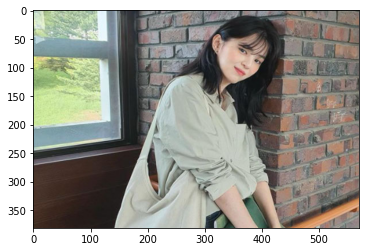

In [9]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hansohee.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 2. DeepLab Model 준비하기

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사전에 학습된 가중치(pretrained weight)를 불러옵니다.

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [12]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (f'원본이미지 사이즈: {img_orig.shape}\n'
       f'resize 이미지 : {img_resized.shape}\n'
       f'seg_map.max: {seg_map.max()}\n')

원본이미지 사이즈: (381, 570, 3)
resize 이미지 : (342, 513, 3)
seg_map.max: 15



In [14]:
# 구글이 제공한 DeepLab의 PASCAL VOC 라벨에서 제공하는 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print(f'DeepLab에서 구분할 수 있는 라벨의 종류: {len(LABEL_NAMES)}')

DeepLab에서 구분할 수 있는 라벨의 종류: 21


## 3. 세그멘테이션

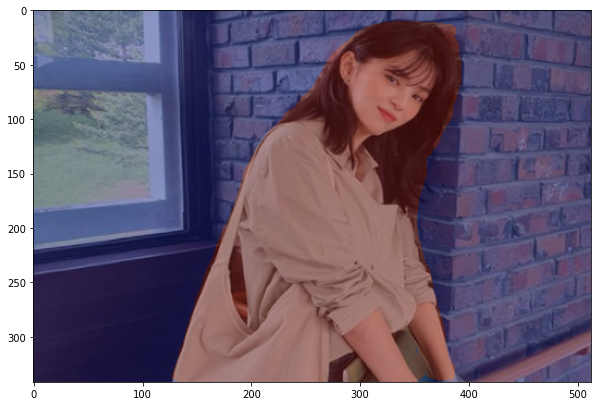

In [15]:
#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

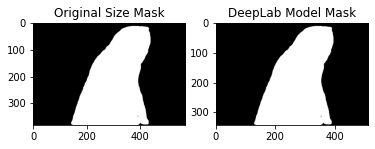

In [20]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

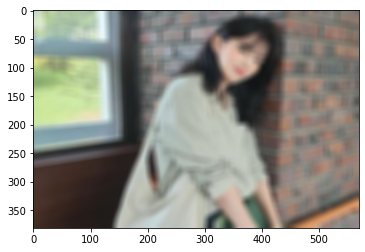

In [19]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

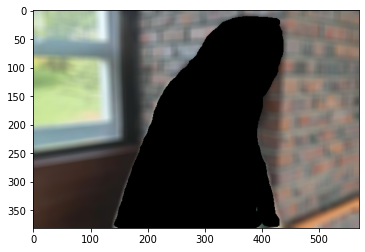

In [22]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

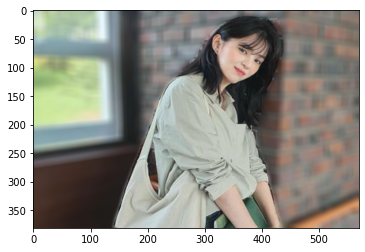

In [60]:
# 배경 영상을 사람 영상과 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점

- 피사체에 속하지 않는데 포함되는 경우 (아래의 빨간색 원)
- 피사체와 밀접하게 segmentation 되지 않음 (A, B)

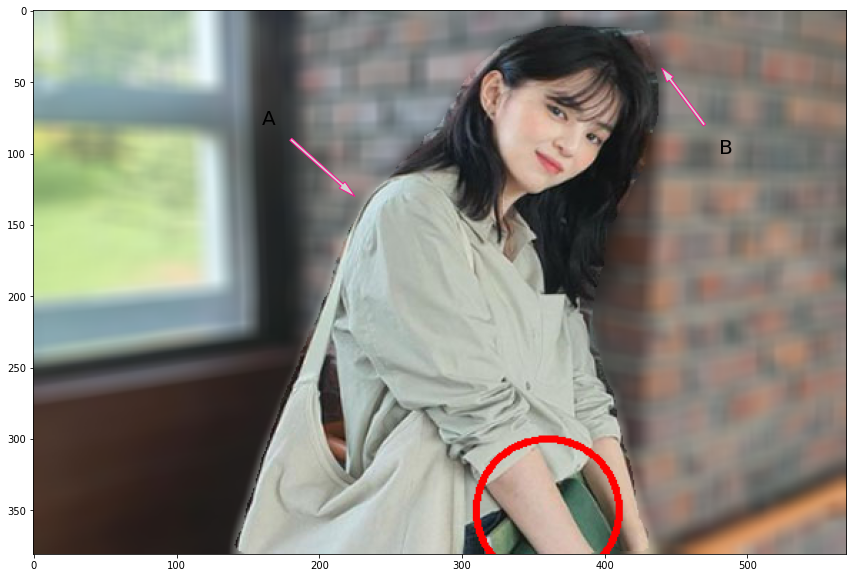

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
ax.add_patch(
    patches.Arrow(
        180,90,45,40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.add_patch(
    patches.Arrow(
        470,80,-30,-40,
        width=10,
        edgecolor = 'deeppink',
        facecolor = 'lightgray'
    ))
ax.text(160, 80, 'A',size=20)
ax.text(480, 100, 'B',size=20)
cv2.circle(img_concat, (360, 350), 50, (0, 0, 255), 3)
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))


plt.show()

## 해결방안

1. 깊이 영상(Depth image) 활용하기
이 방법은 아래의 사이트를 참고했으나 방법을 잡기가 어려웠습니다.
- [Recognizing Depth in Autonomous Driving](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)
- [Unsupervised Learning of Depth and Ego-Motion: A Structured Approach](https://sites.google.com/view/struct2depth)

2. 필터 적용
일단 부자연스럽게 끊기는 부분을 없애는 것은 필터를 적용하는 것만으로 가능하다는 생각이 들어 찾아보게 되었습니다.

찾아본 결과 가우시안 필터(Gaussian Filter)가 적합하다고 판단되어 사용해보기로 했습니다.

In [65]:
# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

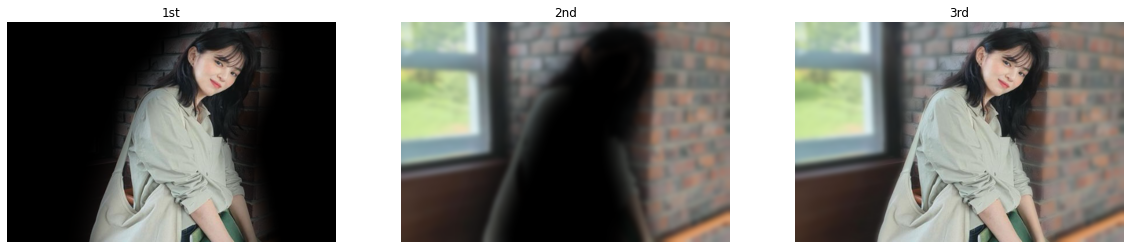

In [66]:
# GaussianBlur 처리한 부분을 확인하기
fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st')
plt.axis('off')
ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd')
plt.axis('off')
ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
plt.title('3rd')
plt.axis('off')
plt.show()

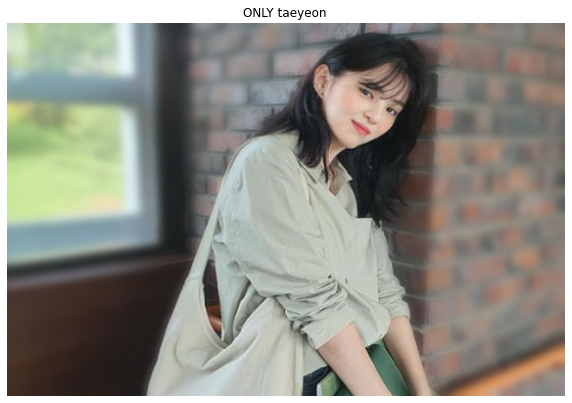

In [67]:
# 결과물 확인
plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
plt.title('ONLY taeyeon ')
plt.axis('off')
plt.show()

# 고찰

추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완하려고 했지만 역시 어렵다.  

하지만 가우시안 Blur를 사용해 피사체의 주변이 부자연스럽게 끊기는 부분은 해결했다.

손으로 잡고있는 책은 옷과 색깔이 유사하기도 하고 사실 사람이 봐도 바지 또는 치마인지 책인지 구분하는 것도 어령